<a href="https://colab.research.google.com/github/cs156/cs156b-proj-group-23/blob/master/Gaussian_Process_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sklearn.gaussian_process as gp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import PairwiseKernel, Product, Sum, RationalQuadratic, Exponentiation
from sklearn.gaussian_process.kernels import Matern
from datetime import datetime
from datetime import date
from sklearn.gaussian_process import GaussianProcessClassifier
import math

# Gaussian Process Regression

Assume every linear combination of the random variables here have are normally distributed, therefore obtaining a probabilistic set of predictions for the model.

# Getting the data inputs

In [ ]:
value = [
    ('AK', 'Alaska'),
    ('AL', 'Alabama'),
    ('AZ', 'Arizona'),
    ('AR', 'Arkansas'),
    ('CA', 'California'),
    ('CO', 'Colorado'),
    ('CT', 'Connecticut'),
    ('DE', 'Delaware'),
    ('FL', 'Florida'),
    ('GA', 'Georgia'),
    ('HI', 'Hawaii'),
    ('ID', 'Idaho'),
    ('IL', 'Illinois'),
    ('IN', 'Indiana'),  
    ('IA', 'Iowa'),
    ('KS', 'Kansas'),
    ('KY', 'Kentucky'),
    ('LA', 'Louisiana'),
    ('ME', 'Maine'),
    ('MD', 'Maryland'),
    ('MA', 'Massachusetts'),
    ('MI', 'Michigan'),
    ('MN', 'Minnesota'),
    ('MS', 'Mississippi'),
    ('MO', 'Missouri'),
    ('MT', 'Montana'),
    ('NE', 'Nebraska'),
    ('NV', 'Nevada'),
    ('NH', 'New Hampshire'),
    ('NJ', 'New Jersey'),
    ('NM', 'New Mexico'),
    ('NY', 'New York State'),
    ('NC', 'North Carolina'),
    ('ND', 'North Dakota'),
    ('OH', 'Ohio'),
    ('OK', 'Oklahoma'),
    ('OR', 'Oregon'),
    ('PA', 'Pennsylvania'),
    ('RI', 'Rhode Island'),
    ('SC', 'South Carolina'),
    ('SD', 'South Dakota'),
    ('TN', 'Tennessee'),
    ('TX', 'Texas'),
    ('UT', 'Utah'),
    ('VT', 'Vermont'),
    ('VA', 'Virginia'),
    ('WA', 'Washington'),
    ('WV', 'West Virginia'),
    ('WI', 'Wisconsin'),
    ('WY', 'Wyoming'),
    ('AS', 'American Samoa'),
    ('DC', 'District of Columbia'),
    ('FM', 'Micronesia'),
    ('GU', 'Guam'),
    ('MH', 'Marshall Islands'),
    ('MP', 'Northern Mariana Islands'),
    ('PR', 'Puerto Rico'),
    ('PW', 'Palau'),
    ('VI', 'Virgin Islands')
]

codes = [a for a, b in value]
names = [b for a, b in value]

to_codes, to_names = {}, {}
for i in range(len(value)):
    to_codes[names[i]] = codes[i]
    to_names[codes[i]] = names[i]

# Code from Basel

# Parsing variant cases
df = pd.read_csv('https://raw.githubusercontent.com/USATODAY/covid-variants/master/!combined.csv')
df.columns = ['Date', 'State', 'B.1.1.7', 'P.1', 'B.1.351', 'Total']
states = list(set(df['State'].to_list()))
states.sort()

variants_per_state = {}
for state in states:
  name = to_names[str(state)]
  variants_per_state[name] = df[df['State'] == state]
  variants_per_state[name] = variants_per_state[name].reset_index(drop=True).dropna()

# code from Andrew

# Parsing vaccine data
df = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv')
states = list(set(df['location'].to_list()))
states.sort()
vaccine_per_state = {}
for state in states:
  vaccine_per_state[state] = df[df['location'] == state]
  vaccine_per_state[state] = vaccine_per_state[state].reset_index(drop=True).dropna()

# code from Andrew

# Parsing total cases
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
parse = list(df.columns)
parse = list(filter(lambda x: '/21' in x and '/21/20' not in x, parse))
df = df[['Province_State'] + parse]
cases_per_state = {}
states = list(set(df['Province_State'].to_list()))
states.sort()

for state in states:
  data = df[df['Province_State'] == state]
  data = data.reset_index(drop=True)
  data = data[parse]
  cases_per_state[state] = pd.DataFrame(data.sum(axis=0)).reset_index()
  cases_per_state[state].columns = ['Date', 'Total_Cases']

# code from Andrew

In [ ]:
# Parsing to time series

# Start Date for data recording
start_date = date(2021, 2, 1)

def time_vaccine_state_data(state):
  vac_t = {}
  for index, row in vaccine_per_state[str(state)].iterrows():
    cur_date = row['date']
    cur_date = datetime.strptime(cur_date, "%Y-%m-%d").date()
    diff = cur_date - start_date
    vac_t[diff.days] = row['total_vaccinations']
  return vac_t

def time_variant_state_data(state):
  var_t = {}
  for index, row in variants_per_state[str(state)].iterrows():
    cur_date = row['Date']
    cur_date = datetime.strptime(cur_date, "%Y-%m-%d").date()
    diff = cur_date - start_date
    var_t[diff.days] = [max(row['B.1.1.7'], 1), max(row['P.1'], 1), max(row['B.1.351'], 1)]
  return var_t

def time_total_state_data(state):
  cases_t = {}
  for index, row in cases_per_state[str(state)].iterrows():
    cur_date = row['Date']
    cur_date = datetime.strptime(cur_date, '%m/%d/%y').date()
    diff = cur_date - start_date
    cases_t[diff.days] = row['Total_Cases']
  return cases_t

# Conglomerating inputs
'''
  @param is the name of the state
  returns a list of lists. Each list-element is [a, b, c, d, e]
  a = Day number (from start date)
  b = Number of cumulative B.1.1.7 cases from day 1 to day a
  c = Number of cumulative P.1 cases from day 1 to day a
  d = Number of cumulative B.1.351 cases from day 1 to day a
  e = Total wild-strain cases from day 1 to day a
'''
def timed_cases(state):
  case_c_t = []
  var_t = time_variant_state_data(state)
  cases_t = time_total_state_data(state)
  for v in var_t:
    if v < 0:
      continue
    cases = cases_t[v]
    case_c_t.append([v] + var_t[v] + [cases - sum(var_t[v])])
  return case_c_t

def timed_vaccine(state):
  vaccine_t = []
  vac_t = time_vaccine_state_data(state)
  for v in vac_t:
    if v < 0:
      continue
    vaccine_t.append([v] + [vac_t[v]])
  return vaccine_t



# Splitting Training and Testing Data

In [ ]:
'''
  @param is the name of the state
  returns 2 lists:
    list1 is the vaccine data
    list2 is the variant data [a, b, c, d] where:
      a = Number of cumulative B.1.1.7 cases
      b = Number of cumulative P.1 cases
      c = Number of cumulative B.1.351 cases
      d = Total wild-strain cases
    The i'th element of list1 was recorded on the same day as the i'th element of list2
'''
def vaccine_variant_data(state):
  cases = timed_cases(state)
  vaccines = timed_vaccine(state)
  x_vaccine = []
  y_variant = []
  a = {}
  x_vaccine = []
  y_variant = []
  days = []
  for i in range(len(cases)):
    a[cases[i][0]] = 1
  for i in range(len(vaccines)):
    try:
      a[vaccines[i][0]] = a[vaccines[i][0]] + 1
    except:
      a[vaccines[i][0]] = 1
  for i in a.keys():
    if (a[i] == 2):
      days.append(i)
      x_vaccine.append(vaccines[i][1])
      y_variant.append([cases[i][1], cases[i][2], cases[i][3], cases[i][4]])
  return np.asarray(x_vaccine), np.asarray(y_variant)

In [ ]:
def split_train_test(state, train_percentage):
  vaccine, variant = vaccine_variant_data(state)
  index = int(train_percentage*len(vaccine)/100)
  train_vaccine, train_variant = vaccine[0:index], variant[0:index]
  test_vaccine, test_variant = vaccine[index:len(vaccine)], variant[index:len(variant)]
  assert(len(train_vaccine)==len(train_variant))
  assert(len(test_vaccine) == len(test_variant))
  return train_vaccine, train_variant, test_vaccine, test_variant

def split_train_test_variant(state, variant, train_percentage):
  train_vaccine, train_variant, test_vaccine, test_variant = split_train_test(state, train_percentage)
  lst = {"B117":0, "P1":1, "B1351":2, "WILDSTRAIN":3}
  train_variant = train_variant[:,lst[variant]]
  test_variant = test_variant[:,lst[variant]]
  assert(len(train_vaccine)==len(train_variant))
  assert(len(test_vaccine) == len(test_variant))
  return train_vaccine, train_variant, test_vaccine, test_variant


In [ ]:
vaccine_tr, b117_tr, vaccine_te, b117_te = split_train_test_variant("California", "B117", 80)

In [ ]:
vaccine_tr, variant_tr, vaccine_te, variant_te = split_train_test("California", 80)

# Model Selection

In [ ]:
kernel = DotProduct() + WhiteKernel() + ConstantKernel(constant_value=200)
model = gp.GaussianProcessRegressor(
                    kernel              = kernel,
                    alpha               = 1e-10,
                    copy_X_train        = True,
                    optimizer           = "fmin_l_bfgs_b",
                    n_restarts_optimizer= 25,
                    normalize_y         = False,
                    random_state        = None)

In [ ]:
model.fit(vaccine_tr.reshape(-1, 1), variant_tr)
params = model.kernel_.get_params()

In [ ]:
sy_pred, std = model.predict(vaccine_te.reshape(-1, 1), return_std=True)

<Figure size 432x288 with 0 Axes>

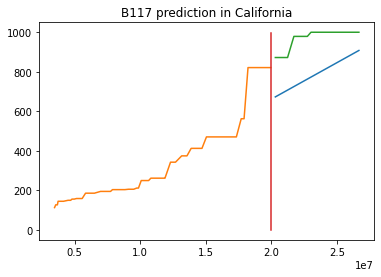

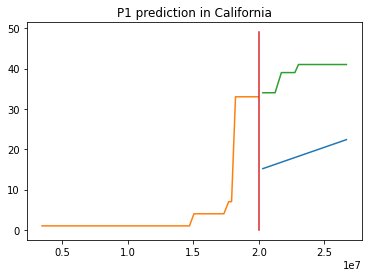

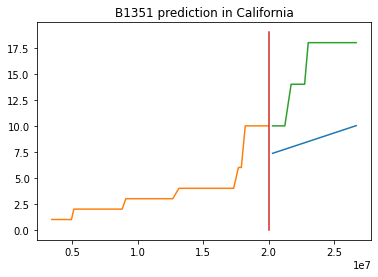

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(vaccine_te, y_pred[:,0])
plt.plot(vaccine_tr, variant_tr[:,0])
plt.plot(vaccine_te, variant_te[:,0])
plt.plot([2.0*1e7 for i in range(1000)], [i for i in range(1000)])
plt.title("B117 prediction in California")
plt.figure()


plt.plot(vaccine_te, y_pred[:,1])
plt.plot(vaccine_tr, variant_tr[:,1])
plt.plot(vaccine_te, variant_te[:,1])
plt.plot([2.0*1e7 for i in range(50)], [i for i in range(50)])
plt.title("P1 prediction in California")
plt.figure()

plt.plot(vaccine_te, y_pred[:,2])
plt.plot(vaccine_tr, variant_tr[:,2])
plt.plot(vaccine_te, variant_te[:,2])
plt.plot([2.0*1e7 for i in range(20)], [i for i in range(20)])
plt.title("B1351 prediction in California")
plt.figure()

In [ ]:
MSE = ((y_pred-variant_te)**2)
print("mse = ", MSE.mean())
print("rmse = ", np.sqrt(MSE.mean()))

mse =  2195163131.3204184
rmse =  46852.56803335777
